# Reddit Sentiment Analysis for ETF Market Prediction

This notebook demonstrates how to scrape Reddit data for sentiment analysis to predict ETF movements in different sectors:
- **Tech Sector**: QQQ (Nasdaq-100), VTI (Total Stock Market)
- **Industrials**: DIA (Dow Jones Industrial Average)
- **Consumer Discretionary**: IWM (Russell 2000), EFA (EAFE)

## Setup and Authentication


In [2]:
# Install required packages (run this cell first if packages are not installed)
# !pip install praw pandas numpy matplotlib seaborn textblob vaderSentiment

import praw
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import re
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Reddit API Setup

To use this notebook, you'll need to create a Reddit app:
1. Go to https://www.reddit.com/prefs/apps
2. Click "Create App" or "Create Another App"
3. Choose "script" as the app type
4. Fill in the required fields and create the app
5. Note down your client_id, client_secret, and user_agent


In [11]:
# Reddit API credentials - Replace with your actual credentials
CLIENT_ID = "x6_wNje4h80DiBvs-Ly6Kw"
CLIENT_SECRET = "PTk8OvQaUcyyq9n0QUhWD9PnpqrgKA"
USER_AGENT = "ETF_Sentiment_Analysis_Bot/1.0"

# Initialize Reddit instance (read-only mode - no username/password needed)
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# Test connection
try:
    print(f"Reddit instance created successfully!")
    print(f"Read-only mode: {reddit.read_only}")
    
    # Test with a simple API call
    test_subreddit = reddit.subreddit('test')
    print(f"✓ Connection test successful!")
    
except Exception as e:
    print(f"✗ Connection failed: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Make sure CLIENT_ID and CLIENT_SECRET are correct")
    print("2. Verify your Reddit app is type 'script'")
    print("3. Check that your app is not suspended")


Reddit instance created successfully!
Read-only mode: True
✓ Connection test successful!


## ETF and Sector Configuration - creating configurations that store keywords for each ETF that can be used to search for news about that ETF


In [5]:
# Define ETFs and their associated keywords for scraping
ETF_CONFIG = {
    'QQQ': {
        'name': 'Invesco QQQ Trust (Nasdaq-100)',
        'sector': 'Technology',
        'keywords': ['QQQ', 'NASDAQ', 'tech stocks', 'technology', 'FAANG', 'Apple', 'Microsoft', 'Amazon', 'Google', 'Meta'],
        'subreddits': ['investing', 'stocks', 'SecurityAnalysis', 'ValueInvesting', 'StockMarket', 'wallstreetbets', 'investing', 'SecurityAnalysis']
    },
    'DIA': {
        'name': 'SPDR Dow Jones Industrial Average ETF',
        'sector': 'Industrials',
        'keywords': ['DIA', 'Dow Jones', 'industrial', 'Boeing', 'Caterpillar', '3M', 'industrial stocks'],
        'subreddits': ['investing', 'stocks', 'SecurityAnalysis', 'ValueInvesting', 'StockMarket', 'wallstreetbets']
    },
    'IWM': {
        'name': 'iShares Russell 2000 ETF',
        'sector': 'Consumer Discretionary',
        'keywords': ['IWM', 'Russell 2000', 'small cap', 'small caps', 'consumer discretionary'],
        'subreddits': ['investing', 'stocks', 'SecurityAnalysis', 'ValueInvesting', 'StockMarket', 'wallstreetbets', 'smallstreetbets']
    },
    'EFA': {
        'name': 'iShares MSCI EAFE ETF',
        'sector': 'International',
        'keywords': ['EFA', 'international', 'EAFE', 'foreign stocks', 'international markets'],
        'subreddits': ['investing', 'stocks', 'SecurityAnalysis', 'ValueInvesting', 'StockMarket', 'investing']
    },
    'VTI': {
        'name': 'Vanguard Total Stock Market ETF',
        'sector': 'Broad Market',
        'keywords': ['VTI', 'total market', 'broad market', 'Vanguard', 'index fund'],
        'subreddits': ['investing', 'stocks', 'SecurityAnalysis', 'ValueInvesting', 'StockMarket', 'Bogleheads']
    }
}

# Initialize sentiment analyzer
vader_analyzer = SentimentIntensityAnalyzer()

print("ETF Configuration loaded successfully!")
for etf, config in ETF_CONFIG.items():
    print(f"{etf}: {config['name']} ({config['sector']})")


ETF Configuration loaded successfully!
QQQ: Invesco QQQ Trust (Nasdaq-100) (Technology)
DIA: SPDR Dow Jones Industrial Average ETF (Industrials)
IWM: iShares Russell 2000 ETF (Consumer Discretionary)
EFA: iShares MSCI EAFE ETF (International)
VTI: Vanguard Total Stock Market ETF (Broad Market)


## Reddit Scraping Functions - cleaning and organizing the post data


In [8]:
def clean_text(text):
    """Clean and preprocess text for sentiment analysis"""
    if not text:
        return ""
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and subreddit references
    text = re.sub(r'u/\w+|r/\w+', '', text)
    
    # Remove special characters but keep basic punctuation
    text = re.sub(r'[^\w\s.,!?]', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text.strip()

def get_sentiment_scores(text):
    """Calculate sentiment scores using multiple methods"""
    if not text or len(text.strip()) < 3:
        return {
            'vader_compound': 0.0,
            'vader_pos': 0.0,
            'vader_neu': 1.0,
            'vader_neg': 0.0,
            'textblob_polarity': 0.0,
            'textblob_subjectivity': 0.0
        }
    
    # VADER sentiment
    vader_scores = vader_analyzer.polarity_scores(text)
    
    # TextBlob sentiment
    blob = TextBlob(text)
    
    return {
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neu': vader_scores['neu'],
        'vader_neg': vader_scores['neg'],
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity
    }

def scrape_subreddit_posts(subreddit_name, query, limit=100, time_filter='week'):
    """Scrape posts from a specific subreddit"""
    try:
        subreddit = reddit.subreddit(subreddit_name)
        posts_data = []
        
        # Search for posts
        for post in subreddit.search(query, limit=limit, time_filter=time_filter):
            post_data = {
                'id': post.id,
                'title': post.title,
                'selftext': post.selftext,
                'score': post.score,
                'upvote_ratio': post.upvote_ratio,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'subreddit': subreddit_name,
                'url': post.url,
                'author': str(post.author) if post.author else '[deleted]'
            }
            posts_data.append(post_data)
        
        return posts_data
    
    except Exception as e:
        print(f"Error scraping r/{subreddit_name}: {str(e)}")
        return []

def scrape_subreddit_comments(subreddit_name, query, limit=50, time_filter='week'):
    """Scrape comments from a specific subreddit"""
    try:
        subreddit = reddit.subreddit(subreddit_name)
        comments_data = []
        
        # Search for posts first, then get their comments
        for post in subreddit.search(query, limit=limit//5, time_filter=time_filter):
            post.comments.replace_more(limit=0)  # Remove 'MoreComments' objects
            
            for comment in post.comments.list()[:10]:  # Limit comments per post
                if hasattr(comment, 'body') and comment.body != '[deleted]':
                    comment_data = {
                        'id': comment.id,
                        'body': comment.body,
                        'score': comment.score,
                        'created_utc': datetime.fromtimestamp(comment.created_utc),
                        'subreddit': subreddit_name,
                        'post_id': post.id,
                        'author': str(comment.author) if comment.author else '[deleted]'
                    }
                    comments_data.append(comment_data)
        
        return comments_data[:limit]  # Ensure we don't exceed the limit
    
    except Exception as e:
        print(f"Error scraping comments from r/{subreddit_name}: {str(e)}")
        return []

print("Reddit scraping functions defined successfully!")


Reddit scraping functions defined successfully!


## ETF-Specific Data Collection


In [9]:
def collect_etf_data(etf_symbol, posts_per_subreddit=20, comments_per_subreddit=30, time_filter='week'):
    """Collect posts and comments for a specific ETF"""
    if etf_symbol not in ETF_CONFIG:
        print(f"ETF {etf_symbol} not found in configuration")
        return None
    
    config = ETF_CONFIG[etf_symbol]
    all_posts = []
    all_comments = []
    
    print(f"Collecting data for {etf_symbol} ({config['name']})...")
    
    for keyword in config['keywords'][:3]:  # Use first 3 keywords to avoid rate limits
        print(f"  Searching for keyword: {keyword}")
        
        for subreddit in config['subreddits'][:3]:  # Use first 3 subreddits
            print(f"    Scraping r/{subreddit}...")
            
            # Scrape posts
            posts = scrape_subreddit_posts(
                subreddit, 
                keyword, 
                limit=posts_per_subreddit, 
                time_filter=time_filter
            )
            
            # Add ETF metadata to posts
            for post in posts:
                post['etf_symbol'] = etf_symbol
                post['etf_name'] = config['name']
                post['sector'] = config['sector']
                post['keyword'] = keyword
            
            all_posts.extend(posts)
            
            # Scrape comments
            comments = scrape_subreddit_comments(
                subreddit, 
                keyword, 
                limit=comments_per_subreddit, 
                time_filter=time_filter
            )
            
            # Add ETF metadata to comments
            for comment in comments:
                comment['etf_symbol'] = etf_symbol
                comment['etf_name'] = config['name']
                comment['sector'] = config['sector']
                comment['keyword'] = keyword
            
            all_comments.extend(comments)
            
            # Rate limiting - be respectful to Reddit's API
            time.sleep(1)
    
    print(f"  Collected {len(all_posts)} posts and {len(all_comments)} comments for {etf_symbol}")
    
    return {
        'posts': all_posts,
        'comments': all_comments,
        'etf_symbol': etf_symbol,
        'etf_name': config['name'],
        'sector': config['sector']
    }

def process_etf_data(etf_data):
    """Process and analyze sentiment for collected ETF data"""
    if not etf_data:
        return None
    
    # Process posts
    posts_df = pd.DataFrame(etf_data['posts'])
    if not posts_df.empty:
        # Combine title and selftext for analysis
        posts_df['combined_text'] = posts_df['title'].fillna('') + ' ' + posts_df['selftext'].fillna('')
        posts_df['cleaned_text'] = posts_df['combined_text'].apply(clean_text)
        
        # Calculate sentiment scores
        sentiment_scores = posts_df['cleaned_text'].apply(get_sentiment_scores)
        sentiment_df = pd.DataFrame(sentiment_scores.tolist())
        posts_df = pd.concat([posts_df, sentiment_df], axis=1)
    
    # Process comments
    comments_df = pd.DataFrame(etf_data['comments'])
    if not comments_df.empty:
        comments_df['cleaned_text'] = comments_df['body'].apply(clean_text)
        
        # Calculate sentiment scores
        sentiment_scores = comments_df['cleaned_text'].apply(get_sentiment_scores)
        sentiment_df = pd.DataFrame(sentiment_scores.tolist())
        comments_df = pd.concat([comments_df, sentiment_df], axis=1)
    
    return {
        'posts_df': posts_df,
        'comments_df': comments_df,
        'etf_symbol': etf_data['etf_symbol'],
        'etf_name': etf_data['etf_name'],
        'sector': etf_data['sector']
    }

print("ETF data collection functions defined successfully!")


ETF data collection functions defined successfully!


## Example Usage: Scraping Data for QQQ (Tech Sector)


In [12]:
# Example: Collect data for QQQ (Tech sector)
print("Starting data collection for QQQ...")
qqq_data = collect_etf_data('QQQ', posts_per_subreddit=15, comments_per_subreddit=20, time_filter='week')

if qqq_data:
    print(f"\nData collection completed!")
    print(f"Posts collected: {len(qqq_data['posts'])}")
    print(f"Comments collected: {len(qqq_data['comments'])}")
    
    # Process the data
    qqq_processed = process_etf_data(qqq_data)
    
    if qqq_processed:
        print(f"\nData processing completed!")
        print(f"Processed posts: {len(qqq_processed['posts_df'])}")
        print(f"Processed comments: {len(qqq_processed['comments_df'])}")
else:
    print("Failed to collect data for QQQ")


Starting data collection for QQQ...
  Searching for keyword: QQQ
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: NASDAQ
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Searching for keyword: tech stocks
    Scraping r/investing...
    Scraping r/stocks...
    Scraping r/SecurityAnalysis...
  Collected 31 posts and 120 comments for QQQ

Data collection completed!
Posts collected: 31
Comments collected: 120

Data processing completed!
Processed posts: 31
Processed comments: 120


## Data Analysis and Visualization


In [16]:
def analyze_sentiment_trends(processed_data):
    """Analyze sentiment trends for collected data"""
    if not processed_data:
        return None
    
    posts_df = processed_data['posts_df']
    comments_df = processed_data['comments_df']
    
    # Combine posts and comments for overall analysis
    all_data = []
    
    if not posts_df.empty:
        posts_analysis = posts_df[['created_utc', 'vader_compound', 'textblob_polarity', 'score', 'upvote_ratio']].copy()
        posts_analysis['type'] = 'post'
        all_data.append(posts_analysis)
    
    if not comments_df.empty:
        comments_analysis = comments_df[['created_utc', 'vader_compound', 'textblob_polarity', 'score']].copy()
        comments_analysis['upvote_ratio'] = 1.0  # Comments don't have upvote_ratio
        comments_analysis['type'] = 'comment'
        all_data.append(comments_analysis)
    
    if not all_data:
        return None
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Calculate daily sentiment averages
    combined_df['date'] = combined_df['created_utc'].dt.date
    daily_sentiment = combined_df.groupby('date').agg({
        'vader_compound': 'mean',
        'textblob_polarity': 'mean',
        'score': 'mean',
        'upvote_ratio': 'mean'
    }).reset_index()
    
    return {
        'daily_sentiment': daily_sentiment,
        'combined_data': combined_df,
        'posts_df': posts_df,
        'comments_df': comments_df
    }

def plot_sentiment_analysis(analysis_data, etf_symbol):
    """Create visualizations for sentiment analysis"""
    if not analysis_data:
        print("No data to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Sentiment Analysis for {etf_symbol}', fontsize=16, fontweight='bold')
    
    daily_sentiment = analysis_data['daily_sentiment']
    combined_data = analysis_data['combined_data']
    
    # Plot 1: Daily sentiment trends
    axes[0, 0].plot(daily_sentiment['date'], daily_sentiment['vader_compound'], 
                   marker='o', linewidth=2, label='VADER Compound')
    axes[0, 0].plot(daily_sentiment['date'], daily_sentiment['textblob_polarity'], 
                   marker='s', linewidth=2, label='TextBlob Polarity')
    axes[0, 0].set_title('Daily Sentiment Trends')
    axes[0, 0].set_ylabel('Sentiment Score')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Sentiment distribution
    axes[0, 1].hist(combined_data['vader_compound'], bins=30, alpha=0.7, label='VADER')
    axes[0, 1].hist(combined_data['textblob_polarity'], bins=30, alpha=0.7, label='TextBlob')
    axes[0, 1].set_title('Sentiment Score Distribution')
    axes[0, 1].set_xlabel('Sentiment Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Score vs Sentiment
    scatter = axes[1, 0].scatter(combined_data['vader_compound'], combined_data['score'], 
                               alpha=0.6, c=combined_data['textblob_polarity'], cmap='RdYlGn')
    axes[1, 0].set_title('Sentiment vs Score')
    axes[1, 0].set_xlabel('VADER Compound Score')
    axes[1, 0].set_ylabel('Reddit Score')
    axes[1, 0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 0], label='TextBlob Polarity')
    
    # Plot 4: Sentiment by type (posts vs comments)
    type_sentiment = combined_data.groupby('type')['vader_compound'].mean()
    axes[1, 1].bar(type_sentiment.index, type_sentiment.values, color=['skyblue', 'lightcoral'])
    axes[1, 1].set_title('Average Sentiment by Content Type')
    axes[1, 1].set_ylabel('Average VADER Compound Score')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n=== Sentiment Analysis Summary for {etf_symbol} ===")
    print(f"Total posts analyzed: {len(analysis_data['posts_df'])}")
    print(f"Total comments analyzed: {len(analysis_data['comments_df'])}")
    print(f"Average VADER compound score: {combined_data['vader_compound'].mean():.3f}")
    print(f"Average TextBlob polarity: {combined_data['textblob_polarity'].mean():.3f}")
    print(f"Sentiment standard deviation: {combined_data['vader_compound'].std():.3f}")
    
    # Sentiment classification
    positive = (combined_data['vader_compound'] > 0.05).sum()
    negative = (combined_data['vader_compound'] < -0.05).sum()
    neutral = len(combined_data) - positive - negative
    
    print(f"\nSentiment Classification:")
    print(f"Positive: {positive} ({positive/len(combined_data)*100:.1f}%)")
    print(f"Neutral: {neutral} ({neutral/len(combined_data)*100:.1f}%)")
    print(f"Negative: {negative} ({negative/len(combined_data)*100:.1f}%)")

print("Analysis and visualization functions defined successfully!")


Analysis and visualization functions defined successfully!


## Run Analysis for QQQ


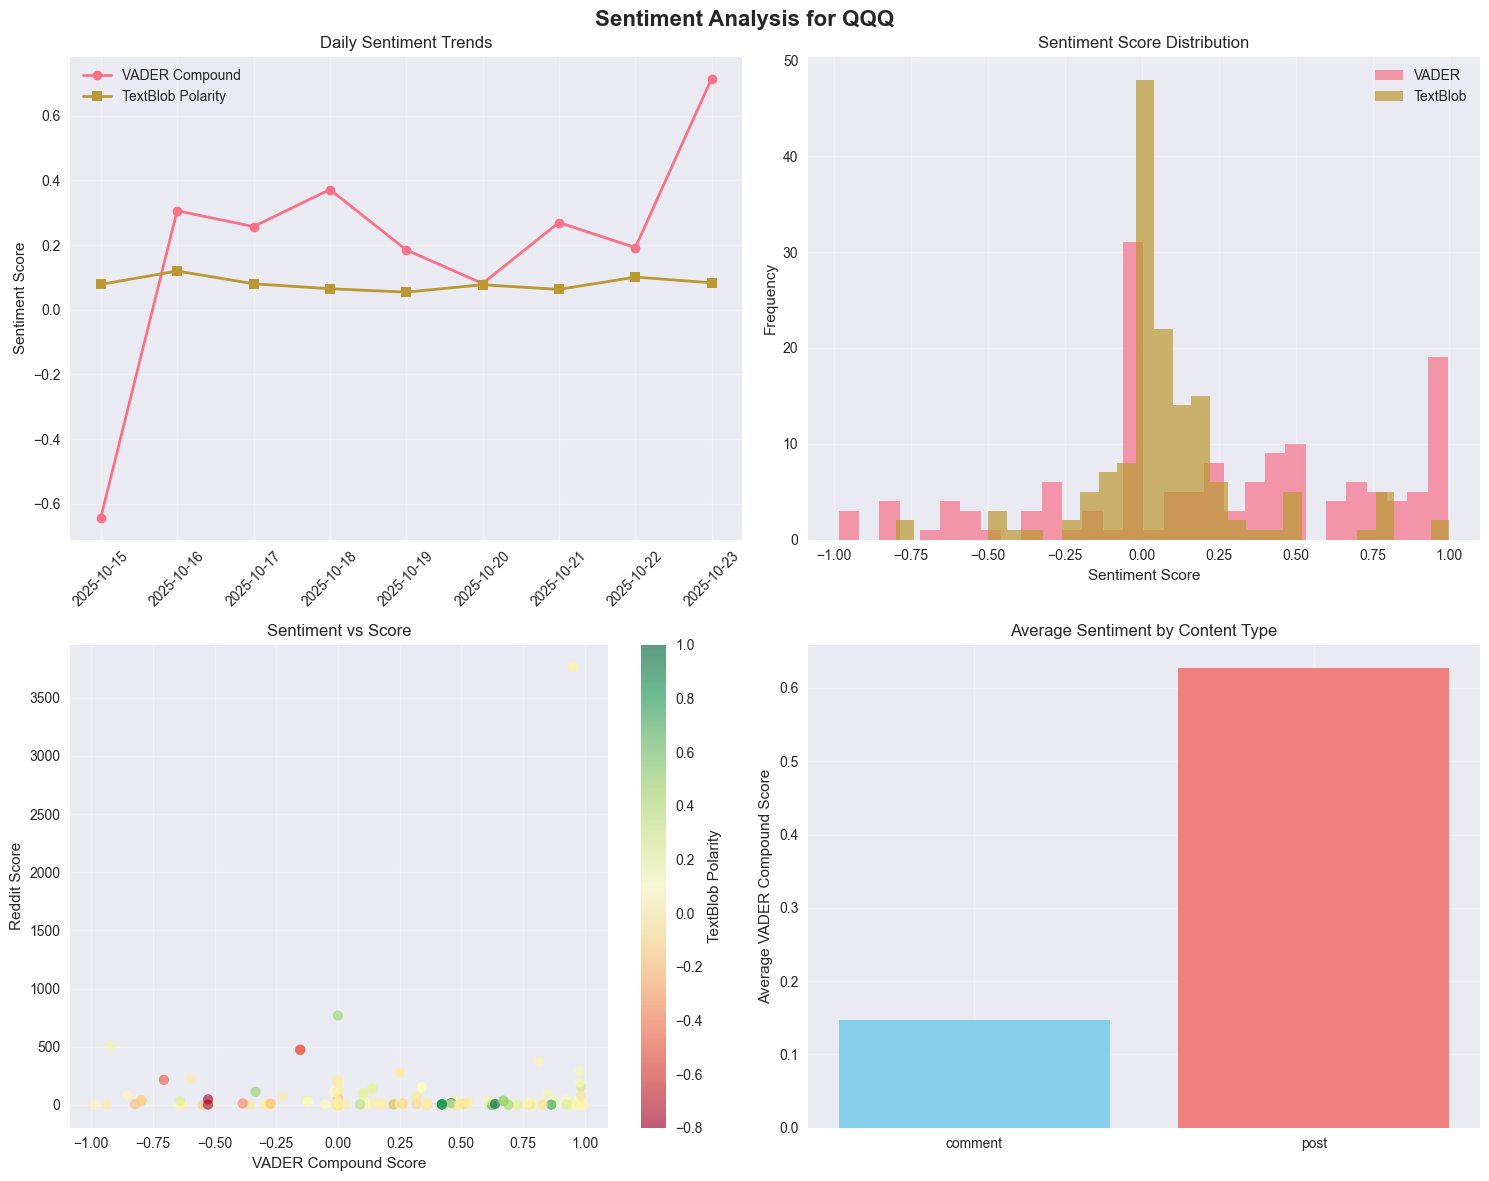


=== Sentiment Analysis Summary for QQQ ===
Total posts analyzed: 31
Total comments analyzed: 120
Average VADER compound score: 0.245
Average TextBlob polarity: 0.078
Sentiment standard deviation: 0.507

Sentiment Classification:
Positive: 89 (58.9%)
Neutral: 31 (20.5%)
Negative: 31 (20.5%)

=== Sample Posts ===
                                                                                  title  vader_compound  textblob_polarity  score
                                             For those wondering about QQQ proxy voting          0.9413           0.245833      5
                                           QQQ Proxy Voting - my research & conclusions          0.9597          -0.005646      9
                                     Market value, adjusted for the value of the dollar          0.6124           0.281481      2
How do you feel about self-directed retirement plan through employer-sponsored 457/401?          0.9636           0.129966      1
                       Who do broker

In [17]:
# Analyze the collected QQQ data
if 'qqq_processed' in locals() and qqq_processed:
    qqq_analysis = analyze_sentiment_trends(qqq_processed)
    
    if qqq_analysis:
        plot_sentiment_analysis(qqq_analysis, 'QQQ')
        
        # Display sample of the data
        print("\n=== Sample Posts ===")
        sample_posts = qqq_processed['posts_df'][['title', 'vader_compound', 'textblob_polarity', 'score']].head()
        print(sample_posts.to_string(index=False))
        
        print("\n=== Sample Comments ===")
        sample_comments = qqq_processed['comments_df'][['body', 'vader_compound', 'textblob_polarity', 'score']].head()
        # Truncate long comments for display
        sample_comments['body'] = sample_comments['body'].str[:100] + '...'
        print(sample_comments.to_string(index=False))
else:
    print("No QQQ data available for analysis. Please run the data collection cell first.")


## Batch Collection for Multiple ETFs


In [ ]:
def collect_multiple_etfs(etf_symbols, posts_per_subreddit=10, comments_per_subreddit=15, time_filter='week'):
    """Collect data for multiple ETFs"""
    all_etf_data = {}
    
    for etf in etf_symbols:
        print(f"\n{'='*50}")
        print(f"Collecting data for {etf}")
        print(f"{'='*50}")
        
        etf_data = collect_etf_data(etf, posts_per_subreddit, comments_per_subreddit, time_filter)
        
        if etf_data:
            processed_data = process_etf_data(etf_data)
            if processed_data:
                all_etf_data[etf] = processed_data
                print(f"✓ Successfully processed {etf}")
            else:
                print(f"✗ Failed to process {etf}")
        else:
            print(f"✗ Failed to collect {etf}")
        
        # Rate limiting between ETFs
        time.sleep(2)
    
    return all_etf_data

def compare_etf_sentiment(all_etf_data):
    """Compare sentiment across multiple ETFs"""
    if not all_etf_data:
        print("No ETF data available for comparison")
        return
    
    comparison_data = []
    
    for etf, data in all_etf_data.items():
        if not data['posts_df'].empty or not data['comments_df'].empty:
            # Combine posts and comments
            all_text_data = []
            
            if not data['posts_df'].empty:
                posts_sentiment = data['posts_df'][['vader_compound', 'textblob_polarity']].copy()
                posts_sentiment['type'] = 'post'
                all_text_data.append(posts_sentiment)
            
            if not data['comments_df'].empty:
                comments_sentiment = data['comments_df'][['vader_compound', 'textblob_polarity']].copy()
                comments_sentiment['type'] = 'comment'
                all_text_data.append(comments_sentiment)
            
            if all_text_data:
                combined_sentiment = pd.concat(all_text_data, ignore_index=True)
                
                etf_summary = {
                    'ETF': etf,
                    'Sector': data['sector'],
                    'Total_Posts': len(data['posts_df']),
                    'Total_Comments': len(data['comments_df']),
                    'Avg_VADER_Compound': combined_sentiment['vader_compound'].mean(),
                    'Avg_TextBlob_Polarity': combined_sentiment['textblob_polarity'].mean(),
                    'Sentiment_Std': combined_sentiment['vader_compound'].std(),
                    'Positive_Ratio': (combined_sentiment['vader_compound'] > 0.05).mean(),
                    'Negative_Ratio': (combined_sentiment['vader_compound'] < -0.05).mean()
                }
                comparison_data.append(etf_summary)
    
    if comparison_data:
        comparison_df = pd.DataFrame(comparison_data)
        
        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('ETF Sentiment Comparison', fontsize=16, fontweight='bold')
        
        # Plot 1: Average sentiment by ETF
        axes[0, 0].bar(comparison_df['ETF'], comparison_df['Avg_VADER_Compound'], 
                      color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
        axes[0, 0].set_title('Average VADER Compound Score by ETF')
        axes[0, 0].set_ylabel('Sentiment Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Sentiment distribution by sector
        sector_sentiment = comparison_df.groupby('Sector')['Avg_VADER_Compound'].mean()
        axes[0, 1].bar(sector_sentiment.index, sector_sentiment.values, 
                      color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
        axes[0, 1].set_title('Average Sentiment by Sector')
        axes[0, 1].set_ylabel('Sentiment Score')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Positive vs Negative ratio
        x = np.arange(len(comparison_df))
        width = 0.35
        axes[1, 0].bar(x - width/2, comparison_df['Positive_Ratio'], width, 
                      label='Positive', color='lightgreen')
        axes[1, 0].bar(x + width/2, comparison_df['Negative_Ratio'], width, 
                      label='Negative', color='lightcoral')
        axes[1, 0].set_title('Positive vs Negative Sentiment Ratio')
        axes[1, 0].set_ylabel('Ratio')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(comparison_df['ETF'], rotation=45)
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Data volume by ETF
        total_volume = comparison_df['Total_Posts'] + comparison_df['Total_Comments']
        axes[1, 1].bar(comparison_df['ETF'], total_volume, 
                      color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
        axes[1, 1].set_title('Total Data Volume by ETF')
        axes[1, 1].set_ylabel('Number of Posts + Comments')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Display comparison table
        print("\n=== ETF Sentiment Comparison Table ===")
        display_cols = ['ETF', 'Sector', 'Total_Posts', 'Total_Comments', 
                       'Avg_VADER_Compound', 'Positive_Ratio', 'Negative_Ratio']
        print(comparison_df[display_cols].round(3).to_string(index=False))
        
        return comparison_df
    
    return None

print("Batch collection and comparison functions defined successfully!")


## Example: Collect Data for All ETFs


In [ ]:
# Collect data for all configured ETFs (this will take some time)
etf_symbols = ['QQQ', 'DIA', 'IWM', 'EFA', 'VTI']

print("Starting batch collection for all ETFs...")
print("This may take several minutes due to rate limiting...")

all_etf_data = collect_multiple_etfs(
    etf_symbols, 
    posts_per_subreddit=8,  # Reduced to avoid rate limits
    comments_per_subreddit=12,  # Reduced to avoid rate limits
    time_filter='week'
)

print(f"\nBatch collection completed!")
print(f"Successfully collected data for {len(all_etf_data)} ETFs: {list(all_etf_data.keys())}")


## Compare All ETFs


In [ ]:
# Compare sentiment across all collected ETFs
if all_etf_data:
    comparison_results = compare_etf_sentiment(all_etf_data)
    
    if comparison_results is not None:
        print("\n=== Key Insights ===")
        
        # Find most positive and negative ETFs
        most_positive = comparison_results.loc[comparison_results['Avg_VADER_Compound'].idxmax()]
        most_negative = comparison_results.loc[comparison_results['Avg_VADER_Compound'].idxmin()]
        
        print(f"Most Positive Sentiment: {most_positive['ETF']} ({most_positive['Sector']}) - Score: {most_positive['Avg_VADER_Compound']:.3f}")
        print(f"Most Negative Sentiment: {most_negative['ETF']} ({most_negative['Sector']}) - Score: {most_negative['Avg_VADER_Compound']:.3f}")
        
        # Find sector with highest sentiment
        sector_avg = comparison_results.groupby('Sector')['Avg_VADER_Compound'].mean().sort_values(ascending=False)
        print(f"\nSector Sentiment Ranking:")
        for sector, score in sector_avg.items():
            print(f"  {sector}: {score:.3f}")
else:
    print("No ETF data available for comparison. Please run the batch collection cell first.")


## Data Export and Saving


In [ ]:
def save_etf_data(all_etf_data, filename_prefix="reddit_sentiment_data"):
    """Save collected ETF data to CSV files"""
    if not all_etf_data:
        print("No data to save")
        return
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    for etf, data in all_etf_data.items():
        # Save posts data
        if not data['posts_df'].empty:
            posts_filename = f"{filename_prefix}_{etf}_posts_{timestamp}.csv"
            data['posts_df'].to_csv(posts_filename, index=False)
            print(f"Saved {len(data['posts_df'])} posts for {etf} to {posts_filename}")
        
        # Save comments data
        if not data['comments_df'].empty:
            comments_filename = f"{filename_prefix}_{etf}_comments_{timestamp}.csv"
            data['comments_df'].to_csv(comments_filename, index=False)
            print(f"Saved {len(data['comments_df'])} comments for {etf} to {comments_filename}")
    
    # Save comparison summary
    if 'comparison_results' in locals() and comparison_results is not None:
        summary_filename = f"{filename_prefix}_comparison_{timestamp}.csv"
        comparison_results.to_csv(summary_filename, index=False)
        print(f"Saved comparison summary to {summary_filename}")

# Save the data (uncomment to save)
# save_etf_data(all_etf_data)

print("Data saving function defined. Uncomment the save_etf_data() call to save your data.")


## Next Steps and Recommendations

### 1. **Data Quality Improvements**
- Implement more sophisticated text preprocessing
- Add domain-specific sentiment lexicons for financial terms
- Filter out spam and low-quality content

### 2. **Advanced Analysis**
- Implement time series analysis to predict ETF movements
- Add correlation analysis between sentiment and actual ETF prices
- Implement machine learning models for sentiment classification

### 3. **Real-time Monitoring**
- Set up automated data collection scripts
- Implement alerting for significant sentiment changes
- Create dashboards for real-time monitoring

### 4. **Integration with Market Data**
- Combine with actual ETF price data from your CSV files
- Implement backtesting strategies based on sentiment signals
- Add technical indicators to sentiment analysis

### 5. **Rate Limiting and Optimization**
- Implement more sophisticated rate limiting
- Use Reddit's pushshift API for historical data
- Consider using multiple Reddit accounts for higher limits

### 6. **Additional Data Sources**
- Integrate with other social media platforms
- Add news sentiment analysis
- Include analyst reports and earnings calls

---

**Note**: Remember to be respectful of Reddit's API terms of service and implement proper rate limiting. The free tier has limitations, so consider upgrading if you need higher data volumes.
